## Neural Machine Translation with Seq2Seq in Keras

In this article, we will see how to create a language translation model which is also a very famous application of neural machine translation. We will use seq2seq architecture to create our language translation model using Python's Keras library.

It is assumed that you have good knowledge of recurrent neural networks, particularly LSTM. The code in this article is written in Python with the Keras library. Therefore, it is assumed that you have good knowledge of the Python language, as well as the Keras library. So, without any further ado, let's begin.

## Libraries and Configuration Settings
As a first step, we will import the required libraries and will configure values for different parameters that we will be using in the code. Let's first import the required libraries:

In [96]:
import os, sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

Execute the following script to set values for different parameters:

In [97]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 20000
MAX_NUM_WORDS = 20000
MAX_SENTENCE_LENGTH = 50
EMBEDDING_SIZE = 100

## The Dataset
The language translation model that we are going to develop in this article will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations. Luckily, such dataset is freely available at this link. Download the file fra-eng.zip and extract it. You will then see the fra.txt file. On each line, the text file contains an English sentence and its French translation, separated by a tab. The first 20 lines of the fra.txt file look like this:

The model contains more than 170,000 records, but we will only use the first 20,000 records to train our model. You can use more records if you want.

## Data Preprocessing
Neural machine translation models are often based on the seq2seq architecture. The seq2seq architecture is an encoder-decoder architecture which consists of two LSTM networks: the encoder LSTM and the decoder LSTM. The input to the encoder LSTM is the sentence in the original language; the input to the decoder LSTM is the sentence in the translated language with a start-of-sentence token. The output is the actual target sentence with an end-of-sentence token.

In our dataset, we do not need to process the input, however, we need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token. Here is the script which does that:

In [98]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'./data/eng-fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)
    
MAX_NUM_WORDS = len(input_sentences)
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In the script above we create three lists input_sentences[], output_sentences[], and output_sentences_inputs[]. Next, in the for loop the fra.txt file is read line by line. Each line is split into two substrings at the position where the tab occurs. The left substring (the English sentence) is inserted into the input_sentences[] list. The substring to the right of the tab is the corresponding translated French sentence. The <eos> token, which marks the end-of-sentence is prefixed to the translated sentence, and the resultant sentence is appended to the output_sentences[] list. Similarly, the <sos> token, which stands for "start of sentence", is concatenated at the start of the translated sentence and the result is added to the output_sentences_inputs[] list. The loop terminates if the number of sentences added to the lists is greater than the NUM_SENTENCES variable, i.e. 20,000.
    
Let's now randomly print a sentence from the input_sentences[], output_sentences[], and output_sentences_inputs[] lists:

In [99]:
print(input_sentences[136])
print(output_sentences[136])
print(output_sentences_inputs[136])

I'm ill.
Je suis malade. <eos>
<sos> Je suis malade.


## Tokenization and Padding
The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

* It divides a sentence into the corresponding list of word
* Then it converts the words to integers

This is extremely important since deep learning and machine learning algorithms work with numbers. The following script is used to tokenize the input sentences:

In [100]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 3532
Length of longest sentence in input: 6


In addition to tokenization and integer conversion, the word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values. The script above also prints the number of unique words in the dictionary and the length of the longest sentence in the input:

Total unique words in the input: 13592

Length of longest sentence in input: 48

Similarly, the output sentences can also be tokenized in the same way as shown below:

In [57]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 9578
Length of longest sentence in the output: 13


From the comparison of the number of unique words in the input and the output, it can be concluded that English sentences are normally shorter and contain a smaller number of words on average, compared to the translated French sentences.

Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM (the algorithm that we are going to train our model) expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In padding, a certain length is defined for a sentence. In our case the length of the longest sentence in the inputs and outputs will be used for padding the input and output sentences, respectively. The longest sentence in the input contains 48 words. For the sentences that contain less than 48 words, zeros will be added in the empty indexes. The following script applies padding to the input sentences.

In [58]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[136]:", encoder_input_sequences[136])

encoder_input_sequences.shape: (20000, 6)
encoder_input_sequences[136]: [  0   0   0   0   7 621]


The script above prints the shape of the padded input sentences. The padded integer sequence for the sentence at index 172 is also printed. Here is the output:

Since there are 20,000 sentences in the input and each input sentence is of length 6, the shape of the input is now (20000, 6). If you look at the integer sequence for the sentence at index 172 of the input sentence, you can see that there are three zeros, followed by the values 6 and 539. You may recall that the original sentence at index 172 is I'm ill. The tokenizer divided the sentence into two words I'm and ill, converted them to integers, and then applied pre-padding by adding three zeros at the start of the corresponding integer sequence for the sentence at index 172 of the input list.

To verify that the integer values for i'm and ill are 6 and 539 respectively, you can pass the words to the word2index_inputs dictionary, as shown below

In [59]:
print(word2idx_inputs["i'm"])
print(word2idx_inputs["ill"])

7
621


In the same way, the decoder outputs and the decoder inputs are padded as follows:

In [60]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[136]:", decoder_input_sequences[136])

decoder_input_sequences.shape: (20000, 13)
decoder_input_sequences[136]: [  2   3  11 199   0   0   0   0   0   0   0   0   0]


The sentence at index 172 of the decoder input is <sos> je suis malade.. If you print the corresponding integers from the word2idx_outputs dictionary, you should see 2, 3, 6, and 188 printed on the console, as shown here:

In [102]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["je"])
print(word2idx_outputs["suis"])
print(word2idx_outputs["malade."])

2
3
11
199


## Word Embeddings
I have written a detailed article on word embeddings, which you may want to check in order to understand word embeddings in Keras. This section only provides the implementation of word embeddings for neural machine translation. However the basic concept remains the same.

Since we are using deep learning models, and deep learning models work with numbers, therefore we need to convert our words into their corresponding numeric vector representations. But we already converted our words into integers. So what's the difference between integer representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

In this article, for English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values, as shown below:

In [66]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'./data/glove.6B/glove.6B.100d.txt', encoding='utf8')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Recall that we have 13592 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.

In [67]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Let's first print the word embeddings for the word ill using the GloVe word embedding dictionary.

In [68]:
print(embeddings_dictionary["ill"])

[ 0.12648    0.1366     0.22192   -0.025204  -0.7197     0.66147
  0.48509    0.057223   0.13829   -0.26375   -0.23647    0.74349
  0.46737   -0.462      0.20031   -0.26302    0.093948  -0.61756
 -0.28213    0.1353     0.28213    0.21813    0.16418    0.22547
 -0.98945    0.29624   -0.62476   -0.29535    0.21534    0.92274
  0.38388    0.55744   -0.14628   -0.15674   -0.51941    0.25629
 -0.0079678  0.12998   -0.029192   0.20868   -0.55127    0.075353
  0.44746   -0.71046    0.75562    0.010378   0.095229   0.16673
  0.22073   -0.46562   -0.10199   -0.80386    0.45162    0.45183
  0.19869   -1.6571     0.7584    -0.40298    0.82426   -0.386
  0.0039546  0.61318    0.02701   -0.3308    -0.095652  -0.082164
  0.7858     0.13394   -0.32715   -0.31371   -0.20247   -0.73001
 -0.49343    0.56445    0.61038    0.36777   -0.070182   0.44859
 -0.61774   -0.18849    0.65592    0.44797   -0.10469    0.62512
 -1.9474    -0.60622    0.073874   0.50013   -1.1278    -0.42066
 -0.37322   -0.50538    0

In the previous section, we saw that the integer representation for the word `wash is 1116`. Let's now check the 1116th index of the word embedding matrix.

In [69]:
print(embedding_matrix[621])

[ 0.12648     0.1366      0.22192    -0.025204   -0.71969998  0.66147
  0.48508999  0.057223    0.13829    -0.26374999 -0.23647     0.74348998
  0.46737    -0.46200001  0.20031001 -0.26302001  0.093948   -0.61756003
 -0.28213     0.1353      0.28213     0.21813001  0.16418     0.22547001
 -0.98944998  0.29624    -0.62475997 -0.29534999  0.21534     0.92273998
  0.38387999  0.55743998 -0.14628001 -0.15673999 -0.51941001  0.25628999
 -0.0079678   0.12998    -0.029192    0.20868    -0.55127001  0.075353
  0.44746    -0.71046001  0.75562     0.010378    0.095229    0.16673
  0.22073001 -0.46562001 -0.10199    -0.80386001  0.45162001  0.45183
  0.19869    -1.65709996  0.75840002 -0.40298     0.82426    -0.38600001
  0.0039546   0.61317998  0.02701    -0.3308     -0.095652   -0.082164
  0.78579998  0.13394    -0.32714999 -0.31371    -0.20247    -0.73000997
 -0.49342999  0.56445003  0.61037999  0.36776999 -0.070182    0.44859001
 -0.61773998 -0.18849     0.65592003  0.44797    -0.10469     0.

You can see that the values for the 621th row in the embedding matrix are similar to the vector representation of the word ill in the GloVe dictionary, which confirms that rows in the embedding matrix represent corresponding word embeddings from the GloVe word embedding dictionary. This word embedding matrix will be used to create the embedding layer for our LSTM model.

The following script creates the embedding layer for the input:

## IMPORTANT

In [70]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

## Creating the Model
Now is the time to develop our model. The first thing we need to do is to define our outputs, as we know that the output will be a sequence of words. Recall that the total number of unique words in the output are 9562. Therefore, each word in the output can be any of the 9562 words. The length of an output sentence is 13. And for each input sentence, we need a corresponding output sentence. Therefore, the final shape of the output will be:

`(number of inputs, length of the output sentence, the number of words in the output)`

In [71]:
decoder_targets_one_hot = np.zeros((
    len(input_sentences),
    max_out_len,
    num_words_output),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 13, 9579)

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word. For instance, the integer representation for ` <sos> je suis malade is [ 2 3 6 188 0 0 0 0 0 0 0 ].` In the decoder_targets_one_hot output array, in the second column of the first row, 1 will be inserted. Similarly, at the third index of the second row, another 1 will be inserted, and so on.

Look at the following script:

In [72]:
for i, d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

Next, we need to create the encoder and decoders. The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

The following script defines the encoder:

In [73]:
encoder_inputs_placeholder = Input(shape=(max_input_len, ))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.

The following script creates the decoder LSTM:

In [74]:
decoder_inputs_placeholder = Input(shape=(max_out_len, ))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs, as shown here:

In [75]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The next step is to compile the model:

In [76]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Let's plot our model to see how it looks:

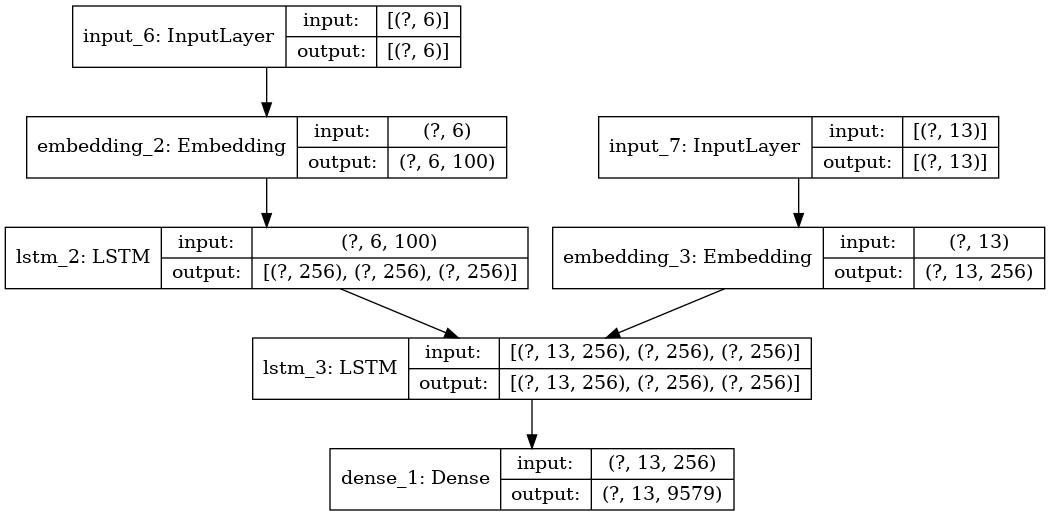

In [77]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

From the output, you can see that we have two types of input. input_1 is the input placeholder for the encoder, which is embedded and passed through lstm_1 layer, which basically is the encoder LSTM. There are three outputs from the lstm_1 layer: the output, the hidden layer and the cell state. However, only the cell state and the hidden state are passed to the decoder.

Here the lstm_2 layer is the decoder LSTM. The input_2 contains the output sentences with <sos> token appended at the start. The input_2 is also passed through an embedding layer and is used as input to the decoder LSTM, lstm_2. Finally, the output from the decoder LSTM is passed through the dense layer to make predictions.

The next step is to train the model using the fit() method:

In [23]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20
282/282 [==============================] - 33s 115ms/step - loss: 1.8540 - accuracy: 0.7467 - val_loss: 1.5608 - val_accuracy: 0.7789
Epoch 2/20
282/282 [==============================] - 30s 106ms/step - loss: 1.0274 - accuracy: 0.8600 - val_loss: 1.1252 - val_accuracy: 0.8556
Epoch 3/20
282/282 [==============================] - 30s 108ms/step - loss: 0.7881 - accuracy: 0.8972 - val_loss: 0.9780 - val_accuracy: 0.8828
Epoch 4/20
282/282 [==============================] - 30s 107ms/step - loss: 0.6639 - accuracy: 0.9148 - val_loss: 0.8878 - val_accuracy: 0.8953
Epoch 5/20
282/282 [==============================] - 30s 107ms/step - loss: 0.5865 - accuracy: 0.9253 - val_loss: 0.8323 - val_accuracy: 0.9054
Epoch 6/20
282/282 [==============================] - 30s 106ms/step - loss: 0.5345 - accuracy: 0.9334 - val_loss: 0.7998 - val_accuracy: 0.9108
Epoch 7/20
282/282 [==============================] - 30s 105ms/step - loss: 0.4952 - accuracy: 0.9396 - val_loss: 0.7713 - val_ac

The model is trained on 18,000 records and tested on the remaining 2,000 records. The model is trained for 20 epochs, you can modify the number of epochs to see if you can get better results. After 20 epochs, I got training accuracy of 90.99% and the validation accuracy of 79.11% which shows that the model is overfitting. To reduce overfitting, you can add dropout or more records. We are only training on 20,0000 records, so you can add more records to reduce overfitting.

## Modifying the Model for Predictions
While training, we know the actual inputs to the decoder for all the output words in the sequence. An example of what happens during training is as follows. Suppose we have a sentence i'm ill. The sentence is translated as follows:

<code class="hljs">// Inputs on the left of Encoder/Decoder, outputs on the right.

Step 1:
I'm ill -&gt; Encoder -&gt; enc(h1,c1)

enc(h1,c1) + &lt;sos&gt; -&gt; Decoder -&gt; je + dec(h1,c1)

step 2:

enc(h1,c1) + je -&gt; Decoder -&gt; suis + dec(h2,c2)

step 3:

enc(h2,c2) + suis -&gt; Decoder -&gt; malade. + dec(h3,c3)

step 3:

enc(h3,c3) + malade. -&gt; Decoder -&gt; &lt;eos&gt; + dec(h4,c4)
</code>

You can see that the input to the decoder and output from the decoder is known and the model is trained on the basis of these inputs and outputs.

However, during predictions the next word will be predicted on the basis of the previous word, which in turn is also predicted in the previous time-step. Now you will understand the purpose of <sos> and <eos> tokens. While making actual predictions, the full output sequence is not available, in fact that is what we have to predict. During prediction the only word available to us is <sos> since all the output sentences start with <sos>.
    
An example of what happens during prediction is as follows. We will again translate the sentence i'm ill:

<code class="hljs">// Inputs on the left of Encoder/Decoder, outputs on the right.

Step 1:

I'm ill -&gt; Encoder -&gt; enc(h1,c1)

enc(h1,c1) + &lt;sos&gt; -&gt; Decoder -&gt; y1(je) + dec(h1,c1)

step 2:

enc(h1,c1) + y1 -&gt; Decoder -&gt; y2(suis) + dec(h2,c2)

step 3:

enc(h2,c2) + y2 -&gt; Decoder -&gt; y3(malade.) + dec(h3,c3)

step 3:

enc(h3,c3) + y3 -&gt; Decoder -&gt; y4(&lt;eos&gt;) + dec(h4,c4)
</code>
    
You can see that the functionality of the encoder remains the same. The sentence in the original language is passed through the encoder and the hidden state, and the cell state is the output from the encoder.

In step 1, the hidden state and cell state of the encoder, and the <sos>, is used as input to the decoder. The decoder predicts a word y1 which may or may not be true. However, as per our model, the probability of correct prediction is 0.7911. At step 2, the decoder hidden state and cell state from step 1, along with y1, is used as input to the decoder, which predicts y2. The process continues until the <eos> token is encountered. All the predicted outputs from the decoder are then concatenated to form the final output sentence. Let's modify our model to implement this logic.

The encoder model remains the same:

In [103]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

Since now at each step we need the decoder hidden and cell states, we will modify our model to accept the hidden and cell states as shown below:

In [25]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Now at each time step, there will be only single word in the decoder input, we need to modify the decoder embedding layer as follows:

In [26]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

Next, we need to create the placeholder for decoder outputs:

In [27]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

To make predictions, the decoder output is passed through the dense layer:

In [28]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

The final step is to define the updated decoder model, as shown here:

In [29]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

Let's now plot our modified decoder LSTM that makes predictions:

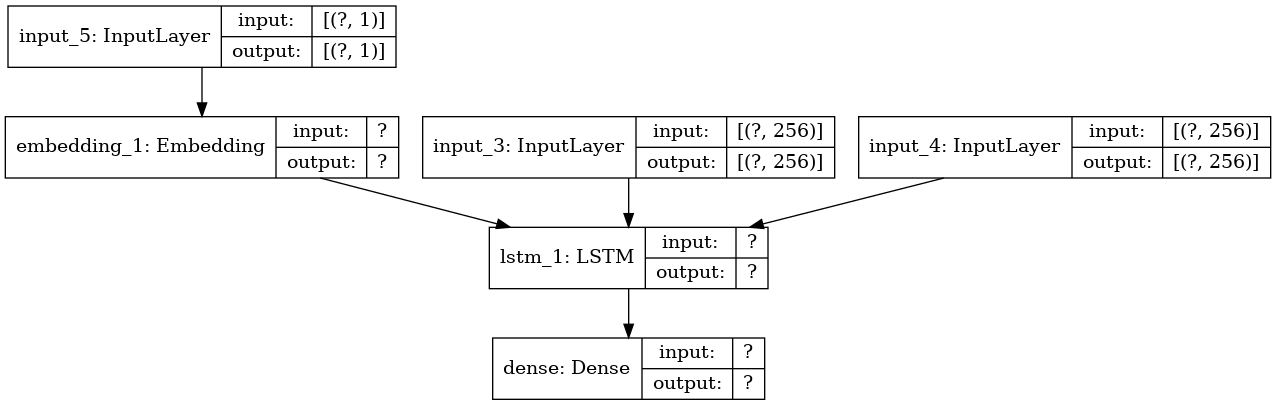

In [30]:
plot_model(decoder_model, to_file="model_plot_dec.png", show_shapes=True, show_layer_names=True)

In the image above lstm_2 is the modified decoder LSTM. You can see that it accepts the sentence with with one word as shown in input_5, and the hidden and cell states from the previous output (input_3 and input_4). You can see that the shape of the of the input sentence is now (none,1) since there will be only one word in the decoder input. On the contrary, during training the shape of the input sentence was (None,6) since the input contained a complete sentence with a maximum length of 6.

## Making Predictions

In this step, you will see how to make predictions using English sentences as inputs.

In the tokenization steps, we converted words to integers. The outputs from the decoder will also be integers. However, we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [104]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

Next we will create a method, i.e. translate_sentence(). The method will accept an input-padded sequence English sentence (in the integer form) and will return the translated French sentence. Look at the translate_sentence() method:

In [115]:
h_ = []
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        h_.append(output_tokens)

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            if word != '<sos>':
                output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In the script above we pass the input sequence to the encoder_model, which predicts the hidden state and the cell state, which are stored in the states_value variable.

Next, we define a variable target_seq, which is a 1 x 1 matrix of all zeros. The target_seq variable contains the first word to the decoder model, which is <sos>.

After that, the eos variable is initialized, which stores the integer value for the <eos> token. In the next line, the output_sentence list is defined, which will contain the predicted translation.

Next, we execute a for loop. The number of execution cycles for the for loop is equal to the length of the longest sentence in the output. Inside the loop, in the first iteration, the decoder_model predicts the output and the hidden and cell states, using the hidden and cell state of the encoder, and the input token, i.e. <sos>. The index of the predicted word is stored in the idx variable. If the value of the predicted index is equal to the <eos> token, the loop terminates. Else if the predicted index is greater than zero, the corresponding word is retrieved from the idx2word dictionary and is stored in the word variable, which is then appended to the output_sentence list. The states_value variable is updated with the new hidden and cell state of the decoder and the index of the predicted word is stored in the target_seq variable. In the next loop cycle, the updated hidden and cell states, along with the index of the previously predicted word, are used to make new predictions. The loop continues until the maximum output sequence length is achieved or the <eos> token is encountered.

Finally, the words in the output_sentence list are concatenated using a space and the resulting string is returned to the calling function.
    
## Testing the Model

To test the code, we will randomly choose a sentence from the input_sentences list, retrieve the corresponding padded sequence for the sentence, and will pass it to the translate_sentence() method. The method will return the translated sentence as shown below.

Here is the script to test the functionality of the model:

In [106]:
# np.argmax(h_[0][0,0,:])
# h_[0][0,0,:]
max_out_len

13

In [117]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i: i+1]
translation = translate_sentence(input_seq)
print('-')
print("Input: ", input_sentences[i])
print('Response: ', translation)

-
Input:  You're overworked.
Response:  
